In [1]:
#Import the libraries
import numpy as np
import pandas as pd

import pickle

import warnings
warnings.filterwarnings("ignore")

## SARIMAX

In [2]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt

### Training KKC with *minimal_SARIMAX*

In [3]:
import sys
sys.path.append('../')

In [4]:
from importlib import reload

from custom_function import minimalSARIMAX

reload(minimalSARIMAX)

from custom_function.minimalSARIMAX import MinimalSARIMAX

In [5]:
train_set = pd.read_csv('6Hsampled_data_set/KKC/train_set.csv')
train_set['WindDirSin'] = np.sin(train_set['WindDir'])*10 + 10
train_set['WindDirCos'] = np.cos(train_set['WindDir'])*10 + 10
train_set['Time'] = pd.to_datetime(train_set['Time'])
train_set = train_set.set_index('Time')

valid_set = pd.read_csv('6Hsampled_data_set/KKC/valid_set.csv')
valid_set['WindDirSin'] = np.sin(valid_set['WindDir'])*10 + 10
valid_set['WindDirCos'] = np.cos(valid_set['WindDir'])*10 + 10
valid_set['Time'] = pd.to_datetime(valid_set['Time'])
valid_set = valid_set.set_index('Time')

test_set = pd.read_csv('6Hsampled_data_set/KKC/test_set.csv')
test_set['WindDirSin'] = np.sin(test_set['WindDir'])*10 + 10
test_set['WindDirCos'] = np.cos(test_set['WindDir'])*10 + 10
test_set['Time'] = pd.to_datetime(test_set['Time'])
test_set = test_set.set_index('Time')

##### Tuning Parameters

In [6]:
order = (2, 0, 1)
seasonal_order = (0, 1, 0, 1461)

exog_order = {}
exog_order['Temp'] = (2, 0, 0)
exog_order['WindSpeed'] = (1, 0, 1)
exog_order['WindDirSin'] = (2, 0, 1)
exog_order['WindDirCos'] = (1, 1, 2)

exog_seasonal_order = {}
exog_seasonal_order['Temp'] = (0, 1, 0, 1461)
exog_seasonal_order['WindSpeed'] = (1, 1, 1, 1461)
exog_seasonal_order['WindDirSin'] = (0, 1, 0, 1461)
exog_seasonal_order['WindDirCos'] = (1, 1, 1, 1461)

exog_columns = ['Temp', 'WindSpeed', 'WindDirSin', 'WindDirCos']

In [7]:
model = {}
model_exog = {}

model = MinimalSARIMAX(train_set[['PM25']],
                          order,
                          seasonal_order,
                          exog=train_set[exog_columns])
    
model_exog = {}
for exog in exog_columns:
    model_exog[exog] = MinimalSARIMAX(train_set[[exog]],
                                      exog_order[exog],
                                      exog_seasonal_order[exog])

In [8]:
model.fit(lr=1e-6, lr_decay=0.999 ,verbose=0)

for exog in exog_columns:
        model_exog[exog].fit(lr=1e-6, lr_decay=0.999, verbose=0)
        n_iter = 1
        if exog=='WindSpeed': n_iter=10
        _ = model_exog[exog].predict_step(train_set[[exog]],
                                          valid_set[[exog]], 
                                          lr=np.array([1e-6]), lr_decay=0.999875, lr_decay_iter=0.95,
                                          step=12, n_iter=n_iter, learn=True, verbose=1)

100%|██████████| 4383/4383 [04:01<00:00, 18.15it/s]


ITER#0  RMSE:8.804285291748457


100%|██████████| 4383/4383 [04:28<00:00, 16.33it/s]


ITER#0  RMSE:15.332282740065667


100%|██████████| 4383/4383 [04:30<00:00, 16.21it/s]


ITER#1  RMSE:14.511339839552395


100%|██████████| 4383/4383 [04:45<00:00, 15.36it/s]


ITER#2  RMSE:14.349084226295867


100%|██████████| 4383/4383 [04:40<00:00, 15.64it/s]


ITER#3  RMSE:14.177332211036562


100%|██████████| 4383/4383 [04:38<00:00, 15.73it/s]


ITER#4  RMSE:13.995478621264667


100%|██████████| 4383/4383 [04:38<00:00, 15.73it/s]


ITER#5  RMSE:13.79952484437516


100%|██████████| 4383/4383 [04:32<00:00, 16.11it/s]


ITER#6  RMSE:13.58546864671578


100%|██████████| 4383/4383 [04:25<00:00, 16.50it/s]


ITER#7  RMSE:13.350757942504709


100%|██████████| 4383/4383 [04:29<00:00, 16.26it/s]


ITER#8  RMSE:13.097362148815344


100%|██████████| 4383/4383 [04:34<00:00, 15.95it/s]


ITER#9  RMSE:12.817501480315308


100%|██████████| 4383/4383 [04:36<00:00, 15.86it/s]


ITER#0  RMSE:9.558714781039429


100%|██████████| 4383/4383 [04:35<00:00, 15.92it/s]

ITER#0  RMSE:10.252098165094578


#### Khonkaen

In [9]:
Result_train = model.predict_step(train_set[['PM25']],
                                  valid_set[['PM25']], 
                                  val_X_exog=train_set[exog_columns],
                                  y_exog=valid_set[exog_columns], 
                                  model_exog=model_exog,
                                  lr=np.array([5e-6, 5e-7, 5e-7, 5e-7, 5e-7]), lr_decay=0.999, lr_decay_iter=0.95,
                                  step=12, n_iter=10, learn=True, verbose=1)

train_pred_sav, val1_pred_sav, Error_save = Result_train

100%|██████████| 4383/4383 [17:45<00:00,  4.11it/s]


ITER#0  RMSE:13.401815541334207


100%|██████████| 4383/4383 [17:32<00:00,  4.16it/s]


ITER#1  RMSE:12.923880173893124


100%|██████████| 4383/4383 [18:18<00:00,  3.99it/s]


ITER#2  RMSE:11.614776666649226


100%|██████████| 4383/4383 [17:15<00:00,  4.23it/s]


ITER#3  RMSE:10.69856693625892


100%|██████████| 4383/4383 [16:50<00:00,  4.34it/s]


ITER#4  RMSE:10.313743139024377


100%|██████████| 4383/4383 [16:43<00:00,  4.37it/s]


ITER#5  RMSE:10.236741621548095


100%|██████████| 4383/4383 [15:50<00:00,  4.61it/s]


ITER#6  RMSE:10.234226762933277


100%|██████████| 4383/4383 [14:59<00:00,  4.87it/s]


ITER#7  RMSE:10.23529802938517


100%|██████████| 4383/4383 [13:47<00:00,  5.30it/s]


ITER#8  RMSE:10.233011847692955


100%|██████████| 4383/4383 [12:41<00:00,  5.75it/s]

ITER#9  RMSE:10.229056729287366


In [10]:
model.params

{'p': array([0.46695899, 0.4954955 ]),
 'pX': array([ 0.05005837,  0.01083436, -0.01726748,  0.00586901]),
 'd': array([0.]),
 'q': array([0.23800153]),
 'P': array([0.]),
 'D': array([0.00895421]),
 'Q': array([0.]),
 'c': 0.08875723523083485}

In [11]:
with open('../model_save/model_kkc.model',"wb") as f:
    pickle.dump(model, f)

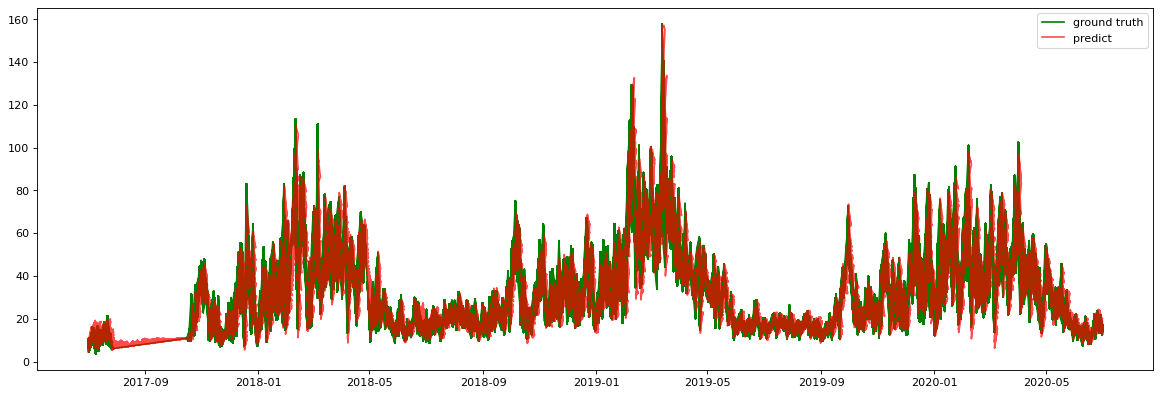

In [12]:
train_X = pd.concat([train_pred_sav, val1_pred_sav])
train_X = train_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(train_X['Actual'], color='g', label='ground truth')
plt.plot(train_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [13]:
Result_test = model.predict_step(valid_set[['PM25']],
                                 test_set[['PM25']], 
                                 val_X_exog=valid_set[exog_columns],
                                 y_exog=test_set[exog_columns], 
                                 model_exog=model_exog,
                                 lr=np.array([5e-7, 5e-7, 5e-7, 5e-7, 5e-7]), lr_decay=0.999875,
                                 step=12, n_iter=1, learn=True, verbose=1)	

val2_pred_sav, test_pred_sav, Error_save = Result_test

100%|██████████| 2779/2779 [08:47<00:00,  5.27it/s]

ITER#0  RMSE:9.504036583184863


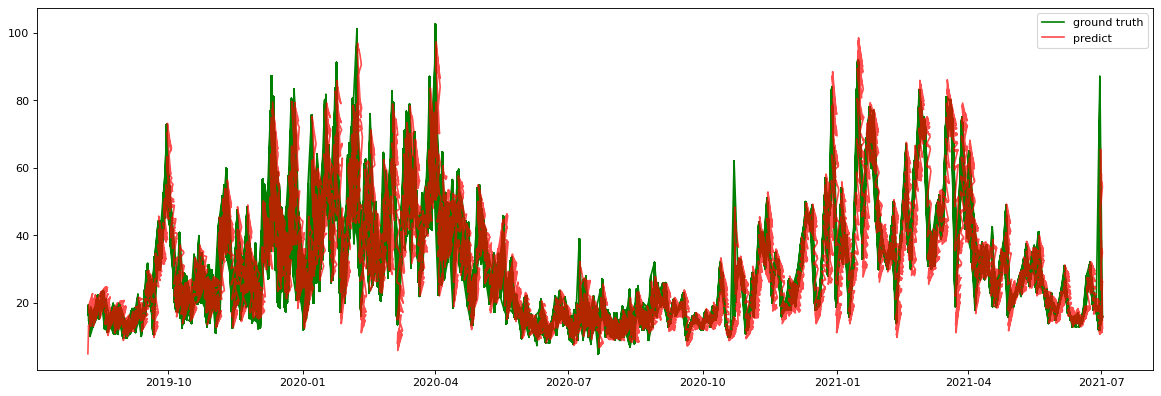

In [14]:
test_X = pd.concat([val2_pred_sav, test_pred_sav])
test_X = test_X.set_index('Time')

plt.figure(num=None, figsize=(18, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test_X['Actual'], color='g', label='ground truth')
plt.plot(test_X['Predict'], alpha=.7, color='r', label='predict')
plt.legend(loc="upper right")

In [15]:
test_pred_sav.to_csv('../answer_dataset/pred_and_actual/y_pred_sav_KKC.csv')